# Convolutional Neural Networks

## Project: Write an Algorithm for Landmark Classification

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to HTML, all the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.

---
### Why We're Here

Photo sharing and photo storage services like to have location data for each photo that is uploaded. With the location data, these services can build advanced features, such as automatic suggestion of relevant tags or automatic photo organization, which help provide a compelling user experience. Although a photo's location can often be obtained by looking at the photo's metadata, many photos uploaded to these services will not have location metadata available. This can happen when, for example, the camera capturing the picture does not have GPS or if a photo's metadata is scrubbed due to privacy concerns.

If no location metadata for an image is available, one way to infer the location is to detect and classify a discernable landmark in the image. Given the large number of landmarks across the world and the immense volume of images that are uploaded to photo sharing services, using human judgement to classify these landmarks would not be feasible.

In this notebook, you will take the first steps towards addressing this problem by building models to automatically predict the location of the image based on any landmarks depicted in the image. At the end of this project, your code will accept any user-supplied image as input and suggest the top k most relevant landmarks from 50 possible landmarks from across the world. The image below displays a potential sample output of your finished project.

![Sample landmark classification output](images/sample_landmark_output.png)


### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Download Datasets and Install Python Modules
* [Step 1](#step1): Create a CNN to Classify Landmarks (from Scratch)
* [Step 2](#step2): Create a CNN to Classify Landmarks (using Transfer Learning)
* [Step 3](#step3): Write Your Landmark Prediction Algorithm

---
<a id='step0'></a>
## Step 0: Download Datasets and Install Python Modules

**Note: if you are using the Udacity workspace, *YOU CAN SKIP THIS STEP*. The dataset can be found in the `/data` folder and all required Python modules have been installed in the workspace.**

Download the [landmark dataset](https://udacity-dlnfd.s3-us-west-1.amazonaws.com/datasets/landmark_images.zip).
Unzip the folder and place it in this project's home directory, at the location `/landmark_images`.

Install the following Python modules:
* cv2
* matplotlib
* numpy
* PIL
* torch
* torchvision

---

<a id='step1'></a>
## Step 1: Create a CNN to Classify Landmarks (from Scratch)

In this step, you will create a CNN that classifies landmarks.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 20%.

Although 20% may seem low at first glance, it seems more reasonable after realizing how difficult of a problem this is. Many times, an image that is taken at a landmark captures a fairly mundane image of an animal or plant, like in the following picture.

<img src="images/train/00.Haleakala_National_Park/084c2aa50d0a9249.jpg" alt="Bird in Haleakalā National Park" style="width: 400px;"/>

Just by looking at that image alone, would you have been able to guess that it was taken at the Haleakalā National Park in Hawaii?

An accuracy of 20% is significantly better than random guessing, which would provide an accuracy of just 2%. In Step 2 of this notebook, you will have the opportunity to greatly improve accuracy by using transfer learning to create a CNN.

Remember that practice is far ahead of theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

**Note**: Remember that the dataset can be found at `/data/landmark_images/` in the workspace.

All three of your data loaders should be accessible via a dictionary named `loaders_scratch`. Your train data loader should be at `loaders_scratch['train']`, your validation data loader should be at `loaders_scratch['valid']`, and your test data loader should be at `loaders_scratch['test']`.

You may find [this documentation on custom datasets](https://pytorch.org/docs/stable/torchvision/datasets.html#datasetfolder) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [1]:
!pip install torch==1.1.0

    100% |████████████████████████████████| 676.9MB 58kB/s  eta 0:00:01    16% |█████▍                          | 113.6MB 30.3MB/s eta 0:00:19    33% |██████████▉                     | 229.9MB 26.7MB/s eta 0:00:17    34% |███████████                     | 234.8MB 41.0MB/s eta 0:00:11    48% |███████████████▍                | 326.6MB 30.4MB/s eta 0:00:12    51% |████████████████▌               | 348.0MB 37.9MB/s eta 0:00:09 |████████████████████▊           | 438.8MB 27.5MB/s eta 0:00:09██████         | 486.5MB 28.2MB/s eta 0:00:07��████████████████████      | 551.5MB 47.4MB/s eta 0:00:03[K    82% |██████████████████████████▎     | 555.9MB 36.6MB/s eta 0:00:04    82% |██████████████████████████▍     | 559.3MB 32.1MB/s eta 0:00:04��████████▌     | 560.8MB 41.3MB/s eta 0:00:03�███████████████████████   | 611.4MB 40.6MB/s eta 0:00:02�███   | 613.2MB 42.2MB/s eta 0:00:02��███████████████████████████   | 615.1MB 39.6MB/s eta 0:00:02.0MB 40.2MB/s eta 0:00:0200:02███████▍ | 642.2MB 28.1MB/s eta

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import random
import os
import torch
import torch.nn as nn 
import torch.nn.functional as F 
import torchvision.models as models
import torch.optim as optim 
import torchvision.transforms as transforms 
from torchvision import datasets
from torch.utils.data import Dataset

In [3]:
num_workers = 0
batch_size = 20
data_train_dir = '/data/landmark_images/train'
data_test_dir = '/data/landmark_images/test'

In [4]:
# create a Dataset object, split and return another Dataset object with the same transforms attribute

class SplitDataSet(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        
    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y
        
    def __len__(self):
        return len(self.subset)

#soruce : https://discuss.pytorch.org/t/torch-utils-data-dataset-random-split/32209

In [5]:
print(torch.__version__)

1.1.0


In [6]:
def image_transforms(phase):
    transform_dict = {
        'train': transforms.Compose(
            [transforms.RandomResizedCrop(256),
             transforms.RandomVerticalFlip(),
             transforms.RandomHorizontalFlip(),
             transforms.RandomRotation(20),
             transforms.ColorJitter(brightness= 0.1, contrast = 0.1, saturation = 0.1, hue = 0.1),
             transforms.ToTensor(),
             transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225]),    
             ]),
         'val': transforms.Compose(
            [transforms.Resize(256),
            transforms.CenterCrop(256), 
             transforms.ToTensor(),
             transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225]),
             ]),
        'test': transforms.Compose(
            [transforms.Resize(256),
            transforms.CenterCrop(256),
             transforms.ToTensor(),
             transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225]),
             ])}
    return transform_dict[phase]

In [7]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

loaders_scratch = {'train': None, 'valid': None, 'test': None}

dataset = datasets.ImageFolder(data_train_dir)

train_set_size = int(len(dataset)*0.75)
valid_set_size = int(len(dataset)) - train_set_size 

train_split, valid_split, = torch.utils.data.random_split(dataset, [train_set_size, valid_set_size])

train_dataset = SplitDataSet(train_split, transform = image_transforms("train"))
val_dataset = SplitDataSet(valid_split, transform =image_transforms("val"))
test_dataset = datasets.ImageFolder(data_test_dir, transform = image_transforms("test"))

loaders_scratch['train'] = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True, num_workers = num_workers)
loaders_scratch['valid'] = torch.utils.data.DataLoader(val_dataset, batch_size = batch_size, shuffle = True, num_workers = num_workers)
loaders_scratch['test'] = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle = False, num_workers = num_workers)

In [8]:
print("Training dataset size: ", len(train_dataset), "\n")
print("Validation dataset size: ", len(val_dataset), "\n")
print("Test dataset size: ", len(test_dataset), "\n")

Training dataset size:  3747 

Validation dataset size:  1249 

Test dataset size:  1250 



**Question 1:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?

**Answer**:

The resize inputs depend of the library we are using and also depends of the method we are using but in  this case, I resized the images with 256x256 shape because it's commonly used in many CNN cases, but I can try with 128x128, 224x224 or antoher shapes. We need to test them and choose the best shape in order to meet our needs. 

I chose to use transforms.RandomResizedCrop, transforms.RandomVerticalFlip(), transforms.RandomHorizontalFlip(),
transforms.RandomRotation() and transforms.ColorJitter() to augment the dataset in order to make better classifications. 

### (IMPLEMENTATION) Visualize a Batch of Training Data

Use the code cell below to retrieve a batch of images from your train data loader, display at least 5 images simultaneously, and label each displayed image with its class name (e.g., "Golden Gate Bridge").

Visualizing the output of your data loader is a great way to ensure that your data loading and preprocessing are working as expected.

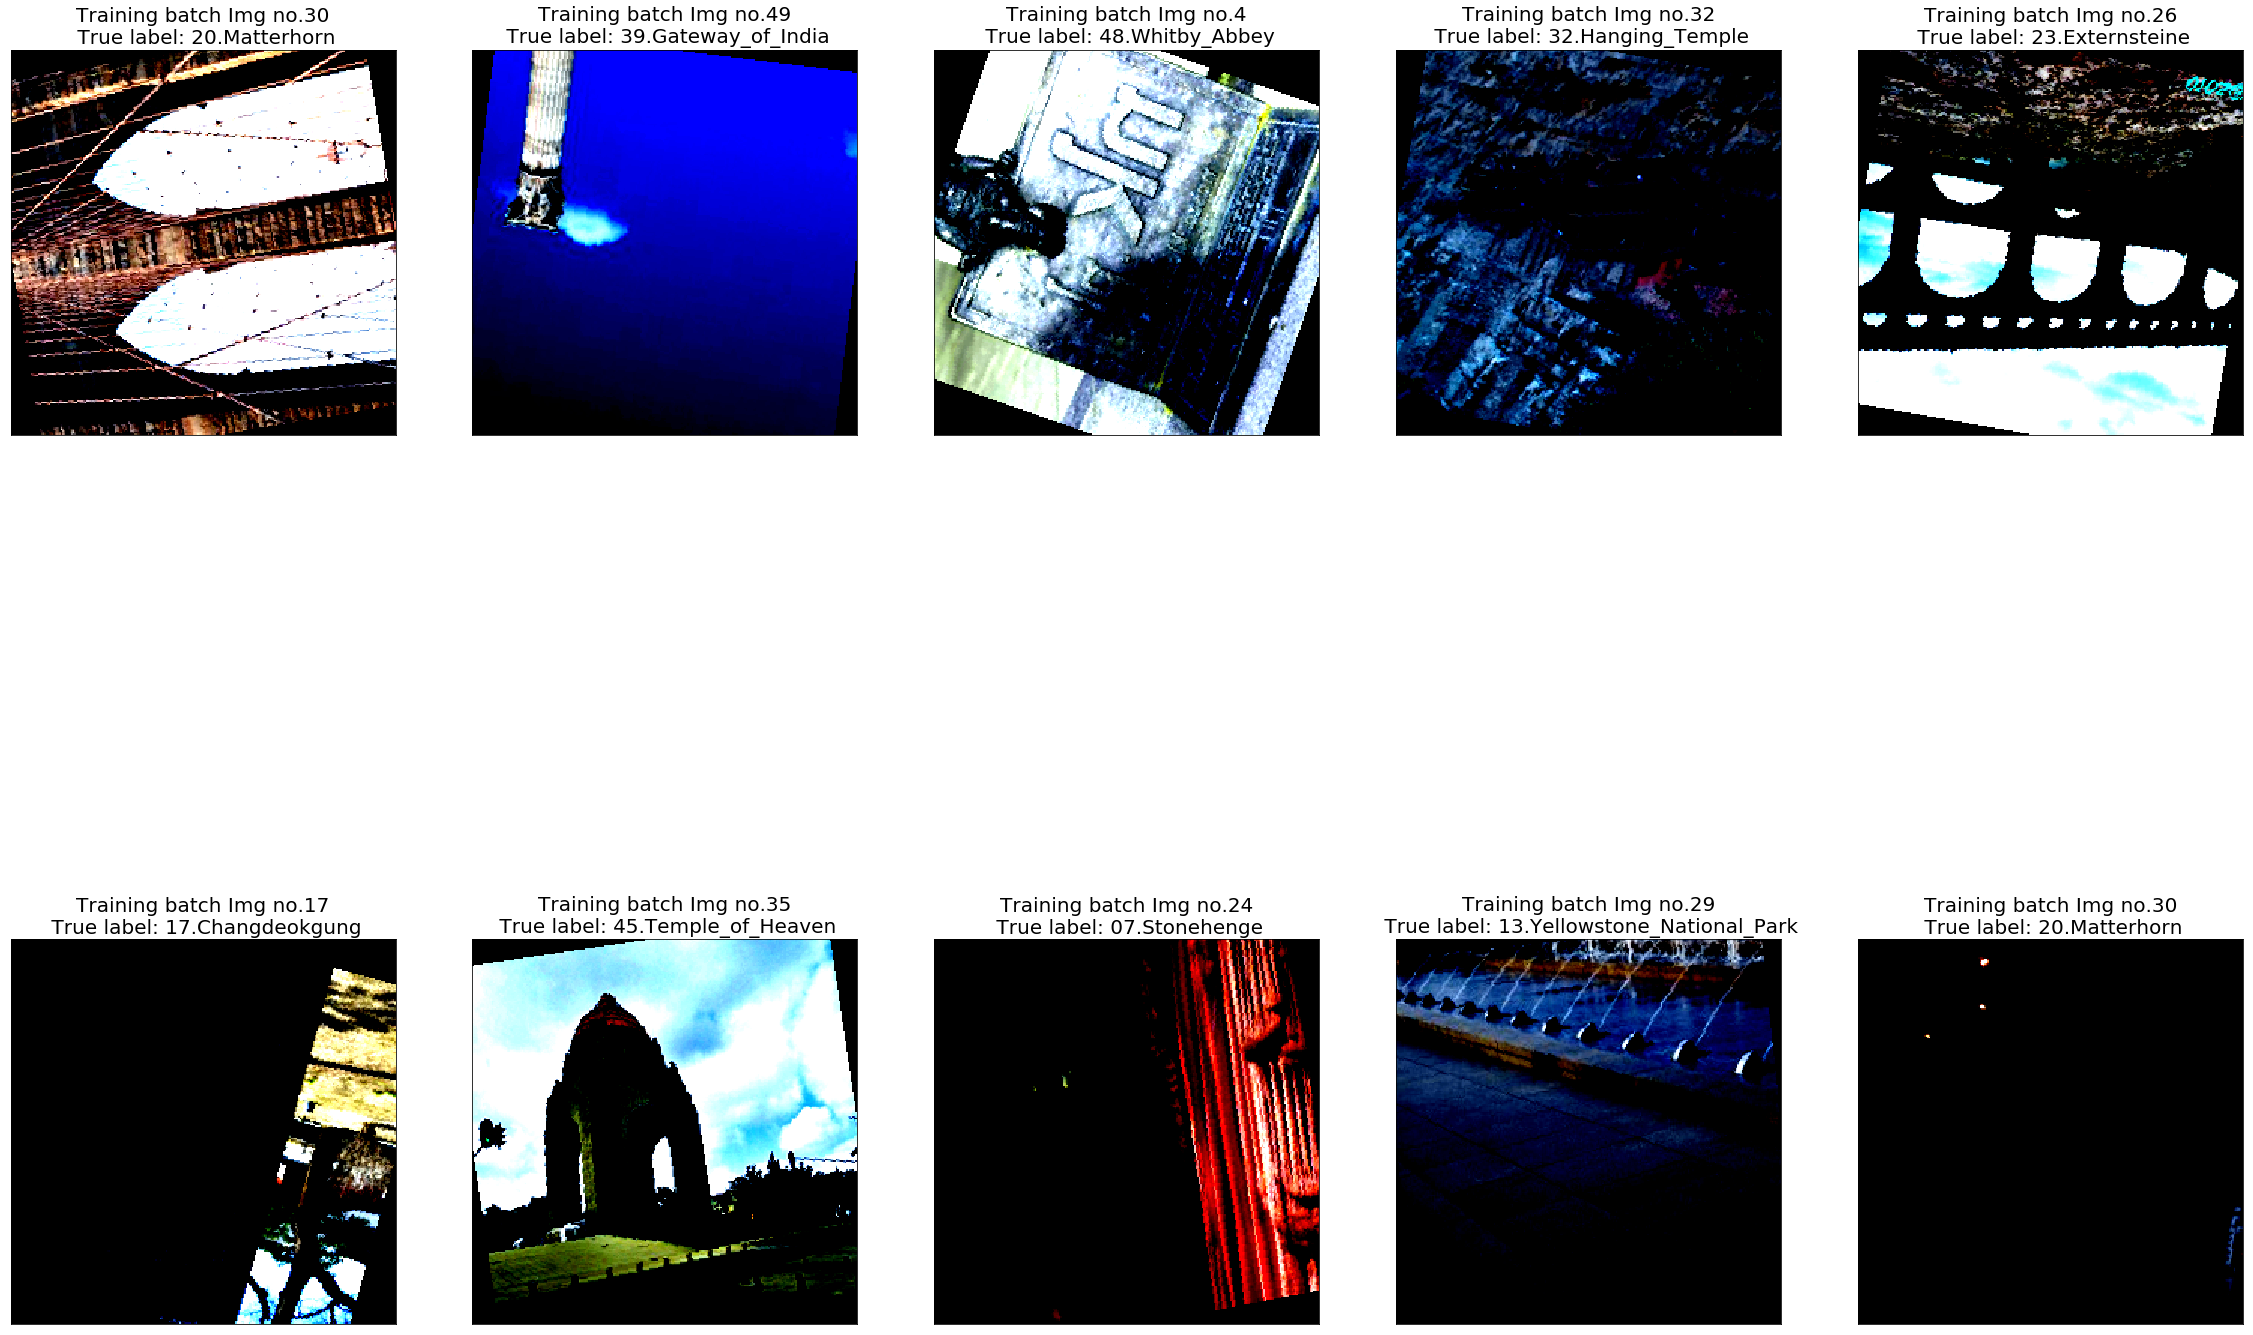

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

## TODO: visualize a batch of the train data loader
## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)

#dataiter = iter(loaders_scratch['train']).next()
images, labels = iter(loaders_scratch['train']).next()
images = images.numpy() #Convert images to numpy from Tensor 
#Plot images 
fig = plt.figure(figsize=(40, 30))

#Display 10 images 
for i in np.arange(10):
    axis = fig.add_subplot(2,10/2,i+1,xticks=[],yticks=[])
    #images[i] = imshow(images[0])
    plt.imshow(np.transpose(images[i],(1,2,0)).clip(0,1))
    plt.title('Training batch Img no.{}\n True label: {}'.format(labels[i], dataset.classes[train_dataset[labels[i]][1]]), fontsize=20)
    

In [10]:
print("\n".join(dataset.classes))

00.Haleakala_National_Park
01.Mount_Rainier_National_Park
02.Ljubljana_Castle
03.Dead_Sea
04.Wroclaws_Dwarves
05.London_Olympic_Stadium
06.Niagara_Falls
07.Stonehenge
08.Grand_Canyon
09.Golden_Gate_Bridge
10.Edinburgh_Castle
11.Mount_Rushmore_National_Memorial
12.Kantanagar_Temple
13.Yellowstone_National_Park
14.Terminal_Tower
15.Central_Park
16.Eiffel_Tower
17.Changdeokgung
18.Delicate_Arch
19.Vienna_City_Hall
20.Matterhorn
21.Taj_Mahal
22.Moscow_Raceway
23.Externsteine
24.Soreq_Cave
25.Banff_National_Park
26.Pont_du_Gard
27.Seattle_Japanese_Garden
28.Sydney_Harbour_Bridge
29.Petronas_Towers
30.Brooklyn_Bridge
31.Washington_Monument
32.Hanging_Temple
33.Sydney_Opera_House
34.Great_Barrier_Reef
35.Monumento_a_la_Revolucion
36.Badlands_National_Park
37.Atomium
38.Forth_Bridge
39.Gateway_of_India
40.Stockholm_City_Hall
41.Machu_Picchu
42.Death_Valley_National_Park
43.Gullfoss_Falls
44.Trevi_Fountain
45.Temple_of_Heaven
46.Great_Wall_of_China
47.Prague_Astronomical_Clock
48.Whitby_Abbey
4

In [11]:
len(dataset.classes)

50

### Initialize use_cuda variable

In [12]:
# useful variable that tells us whether we should use the GPU
use_cuda = torch.cuda.is_available()

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and fill in the function `get_optimizer_scratch` below.

In [13]:
## TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()

def get_optimizer_scratch(model):
    ## TODO: select and return an optimizer
    #return optim.SGD(model.parameters(), lr=0.05)
    return optim.Adam(model.parameters(), lr=0.01)

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify images of landmarks.  Use the template in the code cell below.

In [14]:
import torch.nn as nn

# define the CNN architecture
class Net(nn.Module):
    ## TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        self.conv1 = nn.Conv2d(3, 32, kernel_size = (3,3) , stride=(1, 1), padding=1)
        self.conv1_bn = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size = (3,3) , stride=(1, 1), padding=1) 
        self.conv2_bn = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size = (3,3), stride=(1, 1), padding=1)
        self.conv3_bn = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        
        self.fcl1 = nn.Linear(in_features =128*32*32, out_features=512, bias=True)
        self.fcl1_bn = nn.BatchNorm1d(512)
        self.fcl2 = nn.Linear(in_features = 512, out_features=50, bias=True)
        self.dropout = nn.Dropout(0.2)   
    
    def forward(self, x):
        ## Define forward behavior

        x = self.conv1(x)
        x = self.pool(F.relu(self.conv1_bn(x)))
        x = self.conv2(x)
        x = self.pool(F.relu(self.conv2_bn(x)))
        x = self.conv3(x)
        x = self.pool(F.relu(self.conv3_bn(x)))
        #print(x.shape)
        x = x.view(-1, 128*32*32)
        x= self.dropout(x)
        x = self.fcl1(x)
        x = F.relu(self.fcl1_bn(x))
        x = self.dropout(x)
        x = self.fcl2(x)
        return x
    
    
#-#-# Do NOT modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

__Question 2:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__  


I started with 5 layers, but after test evaluation I turned to 3, because the accuracry didn't better and to avoid overfitting. While initializing the convolutional layers, I have used output channels 16-> 32 -> 64, but I increaed them to 32 -> 64 -> 128, this in order to increase the number of kernels, which convolve over the input volume, so different kernels can learn different things.
https://discuss.pytorch.org/t/why-do-we-want-many-output-channels-in-a-convolutional-neural-network/8789

I used some regularisers like Batch normalization, dropout and Data augmentation, this to improve the performance of the CNN. 

I implemented ReLu activation functions in the input and hidden layers to control how well the network model learns the training dataset. 

### (IMPLEMENTATION) Implement the Training Algorithm

Implement your training algorithm in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at the filepath stored in the variable `save_path`.

In [15]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        # set the module to training mode
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            # Sets the gradients of all optimized 
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            #train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            train_loss += ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))
            
            #train_loss += ((1/(batch_idx+1))*(loss.data.item()-train_loss)


        ######################    
        # validate the model #
        ######################
        # set the model to evaluation mode
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            
            ## TODO: update average validation loss 
            # calculate the output 
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            #valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            valid_loss += ((1 / (batch_idx + 1)) * (loss.data.item() - valid_loss)) 
            """
            with torch.no_grad():
                output = model(data)
                loss = criterion(output, target)
                valid_loss += ((1/(1+batch_idx+1))*(loss.data.item()-valid_loss))
            
            """

        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))

        ## TODO: if the validation loss has decreased, save the model at the filepath stored in save_path
        
        if valid_loss < valid_loss_min:
            print('Saved model validation with loss {:.5f}'.format(valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
            
    return model

### (IMPLEMENTATION) Experiment with the Weight Initialization

Use the code cell below to define a custom weight initialization, and then train with your weight initialization for a few epochs. Make sure that neither the training loss nor validation loss is `nan`.

Later on, you will be able to see how this compares to training with PyTorch's default weight initialization.

In [16]:
def custom_weight_init(m):
    ## TODO: implement a weight initialization strategy
    classname = m.__class__.__name__
    # for every linear layer in the model
    if classname.find('Linear') != -1: # 'Linear' 
        # apply a normar distribution to the weights
        m.weight.data.normal_(0, 1)
        m.bias.data.fill_(0)
        
#-#-# Do NOT modify the code below this line. #-#-#
    
model_scratch.apply(custom_weight_init)
model_scratch = train(10, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch),
                      criterion_scratch, use_cuda, 'ignore.pt')

Epoch: 1 	Training Loss: 9.035144 	Validation Loss: 5.057278
Saved model validation with loss 5.05728
Epoch: 2 	Training Loss: 4.265567 	Validation Loss: 3.896904
Saved model validation with loss 3.89690
Epoch: 3 	Training Loss: 3.915822 	Validation Loss: 3.849830
Saved model validation with loss 3.84983
Epoch: 4 	Training Loss: 3.866759 	Validation Loss: 3.804963
Saved model validation with loss 3.80496
Epoch: 5 	Training Loss: 3.810508 	Validation Loss: 3.699901
Saved model validation with loss 3.69990
Epoch: 6 	Training Loss: 3.778127 	Validation Loss: 3.661318
Saved model validation with loss 3.66132
Epoch: 7 	Training Loss: 3.762438 	Validation Loss: 3.649847
Saved model validation with loss 3.64985
Epoch: 8 	Training Loss: 3.730452 	Validation Loss: 3.622909
Saved model validation with loss 3.62291
Epoch: 9 	Training Loss: 3.687527 	Validation Loss: 3.529333
Saved model validation with loss 3.52933
Epoch: 10 	Training Loss: 3.670954 	Validation Loss: 3.527474
Saved model validati

### (IMPLEMENTATION) Train and Validate the Model

Run the next code cell to train your model.

In [17]:
## TODO: you may change the number of epochs if you'd like,
## but changing it is not required
num_epochs = 20

#-#-# Do NOT modify the code below this line. #-#-#

# function to re-initialize a model with pytorch's default weight initialization
def default_weight_init(m):
    reset_parameters = getattr(m, 'reset_parameters', None)
    if callable(reset_parameters):
        m.reset_parameters()

# reset the model parameters
model_scratch.apply(default_weight_init)

# train the model
model_scratch = train(num_epochs, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch), 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

Epoch: 1 	Training Loss: 3.931228 	Validation Loss: 3.671868
Saved model validation with loss 3.67187
Epoch: 2 	Training Loss: 3.727420 	Validation Loss: 3.587825
Saved model validation with loss 3.58782
Epoch: 3 	Training Loss: 3.681112 	Validation Loss: 3.607551
Epoch: 4 	Training Loss: 3.634098 	Validation Loss: 3.549826
Saved model validation with loss 3.54983
Epoch: 5 	Training Loss: 3.620235 	Validation Loss: 3.480694
Saved model validation with loss 3.48069
Epoch: 6 	Training Loss: 3.600751 	Validation Loss: 3.408591
Saved model validation with loss 3.40859
Epoch: 7 	Training Loss: 3.550570 	Validation Loss: 3.382176
Saved model validation with loss 3.38218
Epoch: 8 	Training Loss: 3.529880 	Validation Loss: 3.379166
Saved model validation with loss 3.37917
Epoch: 9 	Training Loss: 3.511501 	Validation Loss: 3.282374
Saved model validation with loss 3.28237
Epoch: 10 	Training Loss: 3.449488 	Validation Loss: 3.278164
Saved model validation with loss 3.27816
Epoch: 11 	Training 

### (IMPLEMENTATION) Test the Model

Run the code cell below to try out your model on the test dataset of landmark images. Run the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 20%.

In [18]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    # set the module to evaluation mode
    model.eval()

    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 2.872230


Test Accuracy: 26% (335/1250)


---
<a id='step2'></a>
## Step 2: Create a CNN to Classify Landmarks (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify landmarks from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

All three of your data loaders should be accessible via a dictionary named `loaders_transfer`. Your train data loader should be at `loaders_transfer['train']`, your validation data loader should be at `loaders_transfer['valid']`, and your test data loader should be at `loaders_transfer['test']`.

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [19]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

loaders_transfer = {'train': loaders_scratch['train'], 'valid': loaders_scratch['valid'], 
                    'test': loaders_scratch['test']}

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_transfer`, and fill in the function `get_optimizer_transfer` below.

In [20]:
## TODO: select loss function
criterion_transfer = nn.CrossEntropyLoss()

def get_optimizer_transfer(model):
    ## TODO: select and return optimizer
    return optim.Adam(model.parameters(), lr=0.01) 

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify images of landmarks.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [22]:
## TODO: Specify model architecture

import torchvision.models as models

model_transfer = models.vgg16(pretrained=True)

# print in_features, out_features
print(model_transfer.classifier[6].in_features) 
print(model_transfer.classifier[6].out_features) 

# Freeze training for all "features" layers
for param in model_transfer.features.parameters():
    param.requires_grad = False 

In [34]:
print(model_transfer)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [25]:
print(model_transfer.classifier[6].in_features), print(model_transfer.classifier[6].out_features) 

4096
1000


(None, None)

In [27]:
# Freeze training for all "features" layers
for param in model_transfer.features.parameters():
    param.requires_grad = False 

In [33]:
len(dataset.classes)

50

In [30]:
# create last layer
n_inputs = model_transfer.classifier[6].in_features

# add last linear layer 
# new layers automatically have requires_grad = True
last_layer = nn.Linear(n_inputs, len(dataset.classes))

model_transfer.classifier[6] = last_layer


#-#-# Do NOT modify the code below this line. #-#-#
if use_cuda:
    model_transfer = model_transfer.cuda()

__Question 3:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__  

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [31]:
# TODO: train the model and save the best model parameters at filepath 'model_transfer.pt'

model_transfer = train(10, loaders_transfer, model_transfer, get_optimizer_transfer(model_transfer), 
                      criterion_transfer, use_cuda, 'model_transfer.pt')

#-#-# Do NOT modify the code below this line. #-#-#

# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

RuntimeError: size mismatch, m1: [20 x 32768], m2: [25088 x 4096] at /pytorch/aten/src/THC/generic/THCTensorMathBlas.cu:268

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of landmark images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [ ]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

---
<a id='step3'></a>
## Step 3: Write Your Landmark Prediction Algorithm

Great job creating your CNN models! Now that you have put in all the hard work of creating accurate classifiers, let's define some functions to make it easy for others to use your classifiers.

### (IMPLEMENTATION) Write Your Algorithm, Part 1

Implement the function `predict_landmarks`, which accepts a file path to an image and an integer k, and then predicts the **top k most likely landmarks**. You are **required** to use your transfer learned CNN from Step 2 to predict the landmarks.

An example of the expected behavior of `predict_landmarks`:
```
>>> predicted_landmarks = predict_landmarks('example_image.jpg', 3)
>>> print(predicted_landmarks)
['Golden Gate Bridge', 'Brooklyn Bridge', 'Sydney Harbour Bridge']
```

In [ ]:
import cv2
from PIL import Image

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)

def predict_landmarks(img_path, k):
    ## TODO: return the names of the top k landmarks predicted by the transfer learned CNN
    


# test on a sample image
predict_landmarks('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg', 5)

### (IMPLEMENTATION) Write Your Algorithm, Part 2

In the code cell below, implement the function `suggest_locations`, which accepts a file path to an image as input, and then displays the image and the **top 3 most likely landmarks** as predicted by `predict_landmarks`.

Some sample output for `suggest_locations` is provided below, but feel free to design your own user experience!
![](images/sample_landmark_output.png)

In [ ]:
def suggest_locations(img_path):
    # get landmark predictions
    predicted_landmarks = predict_landmarks(img_path, 3)
    
    ## TODO: display image and display landmark predictions

    
    

# test on a sample image
suggest_locations('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg')

### (IMPLEMENTATION) Test Your Algorithm

Test your algorithm by running the `suggest_locations` function on at least four images on your computer. Feel free to use any images you like.

__Question 4:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement)

In [ ]:
## TODO: Execute the `suggest_locations` function on
## at least 4 images on your computer.
## Feel free to use as many code cells as needed.

